# Variational Autoencoder (VAE)

In [1]:
from toolbox import format_time, showLoss, showLatent, showInterpolation
from torch.nn.functional import binary_cross_entropy as BCE
from torchvision.datasets import MNIST, FashionMNIST
from model import VAE_Linear, VAE_Conv2d
from torchsummary import summary
from tqdm.notebook import trange
from torch.optim import RMSprop
from functools import partial
from torch import nn, Tensor
from time import time
import numpy as np
import torch as tr

## Enabling cuda acceleration

In [2]:
assert tr.cuda.is_available(), "CUDA is strongly recommanded, otherwise change value of device to 'cpu'"
device = tr.device('cuda')
tr.manual_seed(196_883)
pass

## Loading and preprocessing data

$\large{X = \{x^1, x^2, \cdots, x^n\} }$

$\large{||X|| = (n,c,w,h)}$

- $n$ is the number of samples
- $c$ is the number of channels (1 $\rightarrow$ grayscale or 3 $\rightarrow$ RGB)
- $w$ is the width (in pixels) of the image
- $h$ is the height (in pixels) of the image

Color range has been normalized from $[0, 255]$ to $[0,1]$

For MNIST :

$\large{Y = \{0, \cdots, 9\}}$

$\large{||Y|| = n}$

### Dataset

In [3]:
# Vanilla MNIST

#train, test = MNIST('./data', True, download = True), MNIST('./data', False)
#train, test = FashionMNIST('./data', True, download = True), FashionMNIST('./data', False)

#transform = lambda im: im.type(tr.float32).reshape(im.shape[0], 1, 28, 28) / 255.0
#X_train, y_train, X_test, y_test = transform(train.data), train.targets, transform(test.data), test.targets
#del train, test, transform

print("min_width", min_width := 7)
print("nb_layers", nb_layers := 3)
print("on_device", on_device := True)

# Precreated datasets

dataset_name: str = "mnist"
#dataset_name: str = "fashion_mnist"
tl = lambda file_name: tr.load(f"Datasets/_binarynumpy/{dataset_name}/{file_name}.pt")
X_train, X_test, y_train, y_test = tl("train_fl"), tl("test_fl"), tl("train_y"), tl("test_y")

#print("min_width", min_width := 7)
#print("nb_layers", nb_layers := 3)
#print("on_device", on_device := True)

#dataset_name = "celebA_32"
#dataset_name = "celebA_64"
#dataset_name = "celebA_128"
#tl = lambda file_name: tr.load(f"Datasets/_binarynumpy/{dataset_name}/{file_name}.pt")
#X_train, X_test, y_train, y_test = tl("train_fl"), tl("test_fl"), None, None

#print("min_width", min_width := 4)
#print("nb_layers", nb_layers := int(np.log2(X_train.shape[-1])) - 1)
#print("on_device", on_device := False)

min_width 7
nb_layers 3
on_device True


## Hyper-parameters

In [4]:
old_shape = X_train.shape
output_shape = np.asarray((*old_shape[2:], old_shape[1]))
assert min_width * 2**(nb_layers -1) == output_shape[0], "Incorrect min_width & nb_layers settings"
input_dim = output_shape.prod()
if on_device:
    X_train, X_test = X_train.to(device), X_test.to(device)

print("batch_size", batch_size := 2**6)
print("lr", lr := 1e-3)
print("is_linear", is_linear := False)
if is_linear:
    X_train, X_test = X_train.view(X_train.size(0), input_dim), X_test.view(X_test.size(0), input_dim)
else:
    print("kernel_size", kernel_size := 5)

print("min_weight", min_weight := 6)
# Growing number of features/weights
print("weights", weights := [2**i for i in range(min_weight, min_weight + nb_layers)])
# Static number of features/weights
# print("weights", weights := [2**min_weight for i in range(nb_layers)])

if is_linear:
    print(f"||X|| = {old_shape} input_dim: {input_dim}")
else:
    print(f"||X|| = {old_shape} output_shape: {output_shape}")

batch_size 64
lr 0.001
is_linear False
kernel_size 5
min_weight 6
weights [64, 128, 256]
||X|| = torch.Size([60000, 1, 28, 28]) output_shape: [28 28  1]


## Building model

### Probabilistic encoder

$\large{q_\phi(Z|X)}$

#### Reparametrization trick

$\large{z = \mu + \sigma \odot \epsilon}$

$\large{\epsilon \sim \mathcal{N}(\mu_x, \sigma_x)}$

In [5]:
def reparameterize(mu: Tensor, log_var: Tensor) -> Tensor:
    std = log_var.mul(0.5).exp_()
    eps = std.data.new(std.size()).normal_()
    return eps.mul(std).add_(mu)

### Probabilistic decoder

$\large{\mathcal{p}_\theta(X|Z)}$

## Criterion (loss function)

$$\large{\mathcal{L_{VAE}}(\theta,\phi) = D_{KL}(q_\phi(Z|X)||p_\theta(Z|X))}$$

Because $\large{D_{KL}(A||B)}$ = $\large{\int\limits_{-\infty}^\infty A(x) \cdot log\frac{A(x)}{B(x)}dx}$

$$\large{= \int q_\phi(Z|X) \cdot log\frac{q_\phi(Z|X)}{p_\theta(Z|X)}dz}$$

Because $\large{p(Z|X) = \frac{p(Z,X)}{p(Z)}}$

$$\large{= \int q_\phi(Z|X) \cdot log\frac{q_\phi(Z|X) \cdot p_\theta(X)}{p_\theta(Z,X)}dz}$$

$$\large{= \int q_\phi(Z|X) \cdot [log(p_\theta(X) + log \frac{q_\phi(Z|X)}{p_\theta(Z,X)}]dz}$$

Because $\large{\int q(Z|X)dz=1}$

$$\large{= log[p_\theta(X)] + \int q_\phi(Z|X) \cdot log \frac{q_\phi(Z|X)}{p_\theta(Z,X)}dz}$$

$$\large{= log[p_\theta(X)] + \int q_\phi(Z|X) \cdot log \frac{q_\phi(Z|X)}{p_\theta(X|Z) \cdot p_\theta(Z)}dz}$$

Because $\large{p(z,x)=p(x|z) \cdot p(z)}$

$$\large{= log[p_\theta(X)] + E_{z\sim q_\phi(Z|X)}[log \frac{q_\phi(Z|X)}{p_\theta(Z)} - log(p_\theta(X|Z))]}$$

$$\large{= log[p_\theta(X)] + D_{KL}(q_\phi(Z|X)||p_\theta(Z))- E_{z\sim q_\phi(Z|X)} log[p_\theta(X|Z)]}$$

### Rearranging terms

$$\large{D_{KL}(q_\phi(Z|X)||p_\theta(Z|X)) = log[p_\theta(X)] + D_{KL}(q_\phi(Z|X)||p_\theta(Z))- E_{z\sim q_\phi(Z|X)} log[p_\theta(X|Z)]}$$

$$\large{log[p_\theta(X)] - D_{KL}(q_\phi(Z|X)||p_\theta(Z|X)) = E_{z\sim q_\phi(Z|X)} log[p_\theta(X|Z)] - D_{KL}(q_\phi(Z|X)||p_\theta(Z))}$$

The LHS of the equation is what we want to maximize when learning the true distributions, soo the negation of the above defines our loss function :

$$\large{\mathcal{L_{VAE}}(\theta,\phi) = - log[p_\theta(X)] + D_{KL}(q_\phi(Z|X)||p_\theta(Z|X))}$$

$$\large{ = - E_{z\sim q_\phi(Z|X)} log[p_\theta(X|Z)] + D_{KL}(q_\phi(Z|X)||p_\theta(Z))}$$

$$\large{\theta^*,\phi^* = argmin_{\theta,\phi}(\mathcal{L_{VAE}})}$$

### Final form (derived)

With

$$\large{BCE = - E_{z\sim q_\phi(Z|X)}[p_\theta(X|Z)]}$$

$$\large{\mathcal{L_{VAE}}(\theta,\phi) = BCE + D_{KL} (q_\phi(Z|X)||p_\theta(Z))}$$

In [6]:
def criterion(output: Tensor, mu: Tensor, log_var: Tensor, x_batch: Tensor,
              batch_size: Tensor, input_dim: np.array) -> Tensor:
    D_KL = -0.5 * tr.sum(1 + log_var - mu.pow(2) - log_var.exp())
    D_KL /= batch_size * input_dim
    return BCE(output, x_batch) + D_KL

## Creating the model

In [7]:
if is_linear:
    model = VAE_Linear(reparameterize, weights, device, input_dim = input_dim)
    summary(model, (1, input_dim))
else:
    model = VAE_Conv2d(reparameterize, weights, device, output_shape, kernel_size, min_width)
    summary(model, tuple(output_shape[::-1]))
optimizer = RMSprop(model.parameters(), lr)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,664
              ReLU-2           [-1, 64, 14, 14]               0
          Conv2d_R-3           [-1, 64, 14, 14]               0
            Conv2d-4            [-1, 128, 7, 7]         204,928
              ReLU-5            [-1, 128, 7, 7]               0
          Conv2d_R-6            [-1, 128, 7, 7]               0
            Conv2d-7            [-1, 256, 4, 4]         819,456
              ReLU-8            [-1, 256, 4, 4]               0
          Conv2d_R-9            [-1, 256, 4, 4]               0
          Flatten-10                 [-1, 4096]               0
           Linear-11                    [-1, 2]           8,194
           Linear-12                    [-1, 2]           8,194
           Linear-13                   [-1, 49]             147
             ReLU-14                   

## Training the model

In [8]:
def train(X_train: Tensor, X_test: Tensor, nb_epoch: int, show_loss_interval: int) -> np.array:
    hist = {f"{name}_loss": np.empty(nb_epoch, dtype = np.float32) for name in ["train", "test"]}
    last_time = time()
    total_time_spent = 0.0
    train_size, test_size = X_train.shape[0], X_test.shape[0]
    n_train_batches, n_test_batches = np.ceil(train_size / batch_size), np.ceil(test_size / batch_size)
    
    model.train()
    print("Begining of training")
    for epoch in trange(1, nb_epoch + 1, position = 0, desc = 'Epoch', leave = False):
        batch_loss = 0.0
        for batch_idx in trange(0, train_size, batch_size, position = 1, desc = 'Batch train', leave = False):
            X_batch = X_train[batch_idx : batch_idx + batch_size]
            if not on_device:
                X_batch = X_batch.to(device)
            model.zero_grad()
            output, mu, log_var = model(X_batch)
            loss = criterion(output, mu, log_var, X_batch, batch_size, input_dim)
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
            if not on_device:
                del X_batch

        hist["train_loss"][epoch - 1] = batch_loss / n_train_batches
        
        batch_loss = 0.0
        for batch_idx in trange(0, test_size, batch_size, position = 1, desc = 'Batch test', leave = False):
            X_batch = X_test[batch_idx : batch_idx + batch_size]
            if not on_device:
                X_batch = X_batch.to(device)
            output, mu, log_var = model(X_batch)
            loss = criterion(output, mu, log_var, X_batch, batch_size, input_dim)
            batch_loss += loss.item()
            if not on_device:
                del X_batch

        hist["test_loss"][epoch - 1] = batch_loss / n_test_batches

        if epoch % show_loss_interval == 0:
            time_spent = time() - last_time
            last_time += time_spent
            total_time_spent += time_spent
            print(f"Epoch {epoch:04d} == {hist['train_loss'][epoch - 1]:.5f}", end = " | ")
            print(f"{hist['test_loss'][epoch - 1]:.5f}", end = " - ")
            print(format_time(time_spent))

    print(f"Ending of training, spent {format_time(total_time_spent)} training")
    model.eval()
    return hist

In [9]:
from IPython.display import HTML
"""
    Dirty fix to hide JupyterLab's display bug of tqdm(leave = False)

    Source : https://github.com/jupyterlab/jupyterlab/issues/7354#issuecomment-1282893131
"""
HTML("""
<pre>Applying stylesheet</pre>
<style>
    .jp-OutputArea-child:has(.jp-OutputArea-prompt:empty) {
          padding: 0 !important;
    }
</style>""")

In [10]:
hist = train(X_train, X_test, 50, 1)

Begining of training


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0001 == 0.24725 | 0.21912 - 6s 986ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0002 == 0.20674 | 0.20837 - 6s 807ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0003 == 0.19692 | 0.20152 - 6s 928ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0004 == 0.19255 | 0.19977 - 6s 820ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0005 == 0.19012 | 0.19530 - 6s 939ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0006 == 0.18830 | 0.19427 - 6s 879ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0007 == 0.18685 | 0.19279 - 6s 857ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0008 == 0.18581 | 0.19392 - 6s 895ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0009 == 0.18498 | 0.19760 - 6s 914ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0010 == 0.18422 | 0.19068 - 6s 945ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0011 == 0.18362 | 0.19088 - 6s 887ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0012 == 0.18295 | 0.19006 - 6s 940ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0013 == 0.18254 | 0.18931 - 6s 971ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0014 == 0.18211 | 0.19172 - 6s 889ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0015 == 0.18174 | 0.18890 - 6s 985ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0016 == 0.18138 | 0.18939 - 6s 961ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0017 == 0.18106 | 0.19623 - 6s 939ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0018 == 0.18064 | 0.18822 - 6s 933ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0019 == 0.18041 | 0.18809 - 6s 916ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0020 == 0.18014 | 0.18868 - 6s 945ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0021 == 0.17985 | 0.18920 - 6s 914ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0022 == 0.17976 | 0.18718 - 6s 937ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0023 == 0.17939 | 0.18985 - 6s 938ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0024 == 0.17924 | 0.18773 - 6s 940ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0025 == 0.17907 | 0.19093 - 6s 928ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0026 == 0.17876 | 0.18691 - 7s 89ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0027 == 0.17855 | 0.18989 - 6s 992ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0028 == 0.17842 | 0.18711 - 7s 311ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0029 == 0.17817 | 0.19148 - 7s 36ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0030 == 0.17799 | 0.18738 - 7s 114ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0031 == 0.17787 | 0.19139 - 7s 164ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0032 == 0.17774 | 0.18645 - 6s 758ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0033 == 0.17753 | 0.18651 - 6s 754ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0034 == 0.17737 | 0.18699 - 6s 863ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0035 == 0.17726 | 0.18624 - 6s 744ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0036 == 0.17700 | 0.19117 - 6s 775ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0037 == 0.17694 | 0.18902 - 6s 757ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0038 == 0.17688 | 0.18934 - 6s 889ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0039 == 0.17668 | 0.19156 - 7s 327ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0040 == 0.17644 | 0.18886 - 6s 838ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0041 == 0.17635 | 0.18686 - 6s 797ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0042 == 0.17633 | 0.18797 - 6s 776ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0043 == 0.17627 | 0.18855 - 6s 794ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0044 == 0.17604 | 0.18909 - 6s 808ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0045 == 0.17596 | 0.18704 - 6s 778ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0046 == 0.17590 | 0.18657 - 6s 791ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0047 == 0.17570 | 0.18683 - 6s 769ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0048 == 0.17562 | 0.18725 - 6s 773ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0049 == 0.17546 | 0.18735 - 6s 777ms


Batch train:   0%|          | 0/938 [00:00<?, ?it/s]

Batch test:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0050 == 0.17542 | 0.18806 - 6s 760ms
Ending of training, spent 5m 45s 254ms training


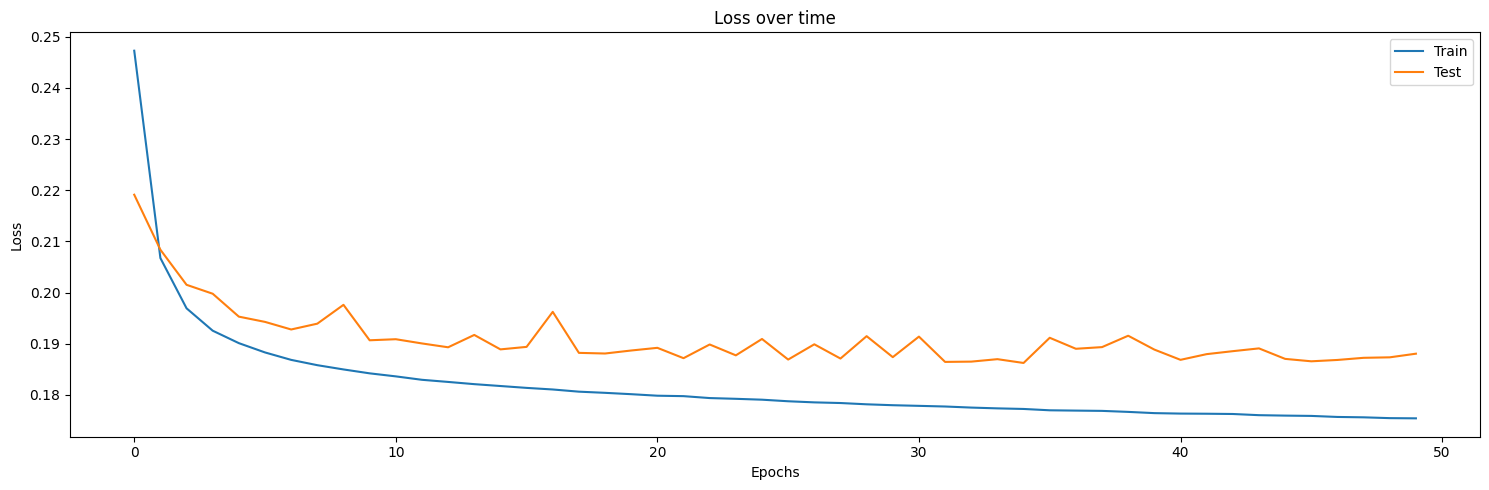

In [11]:
showLoss(hist)

## Latent space

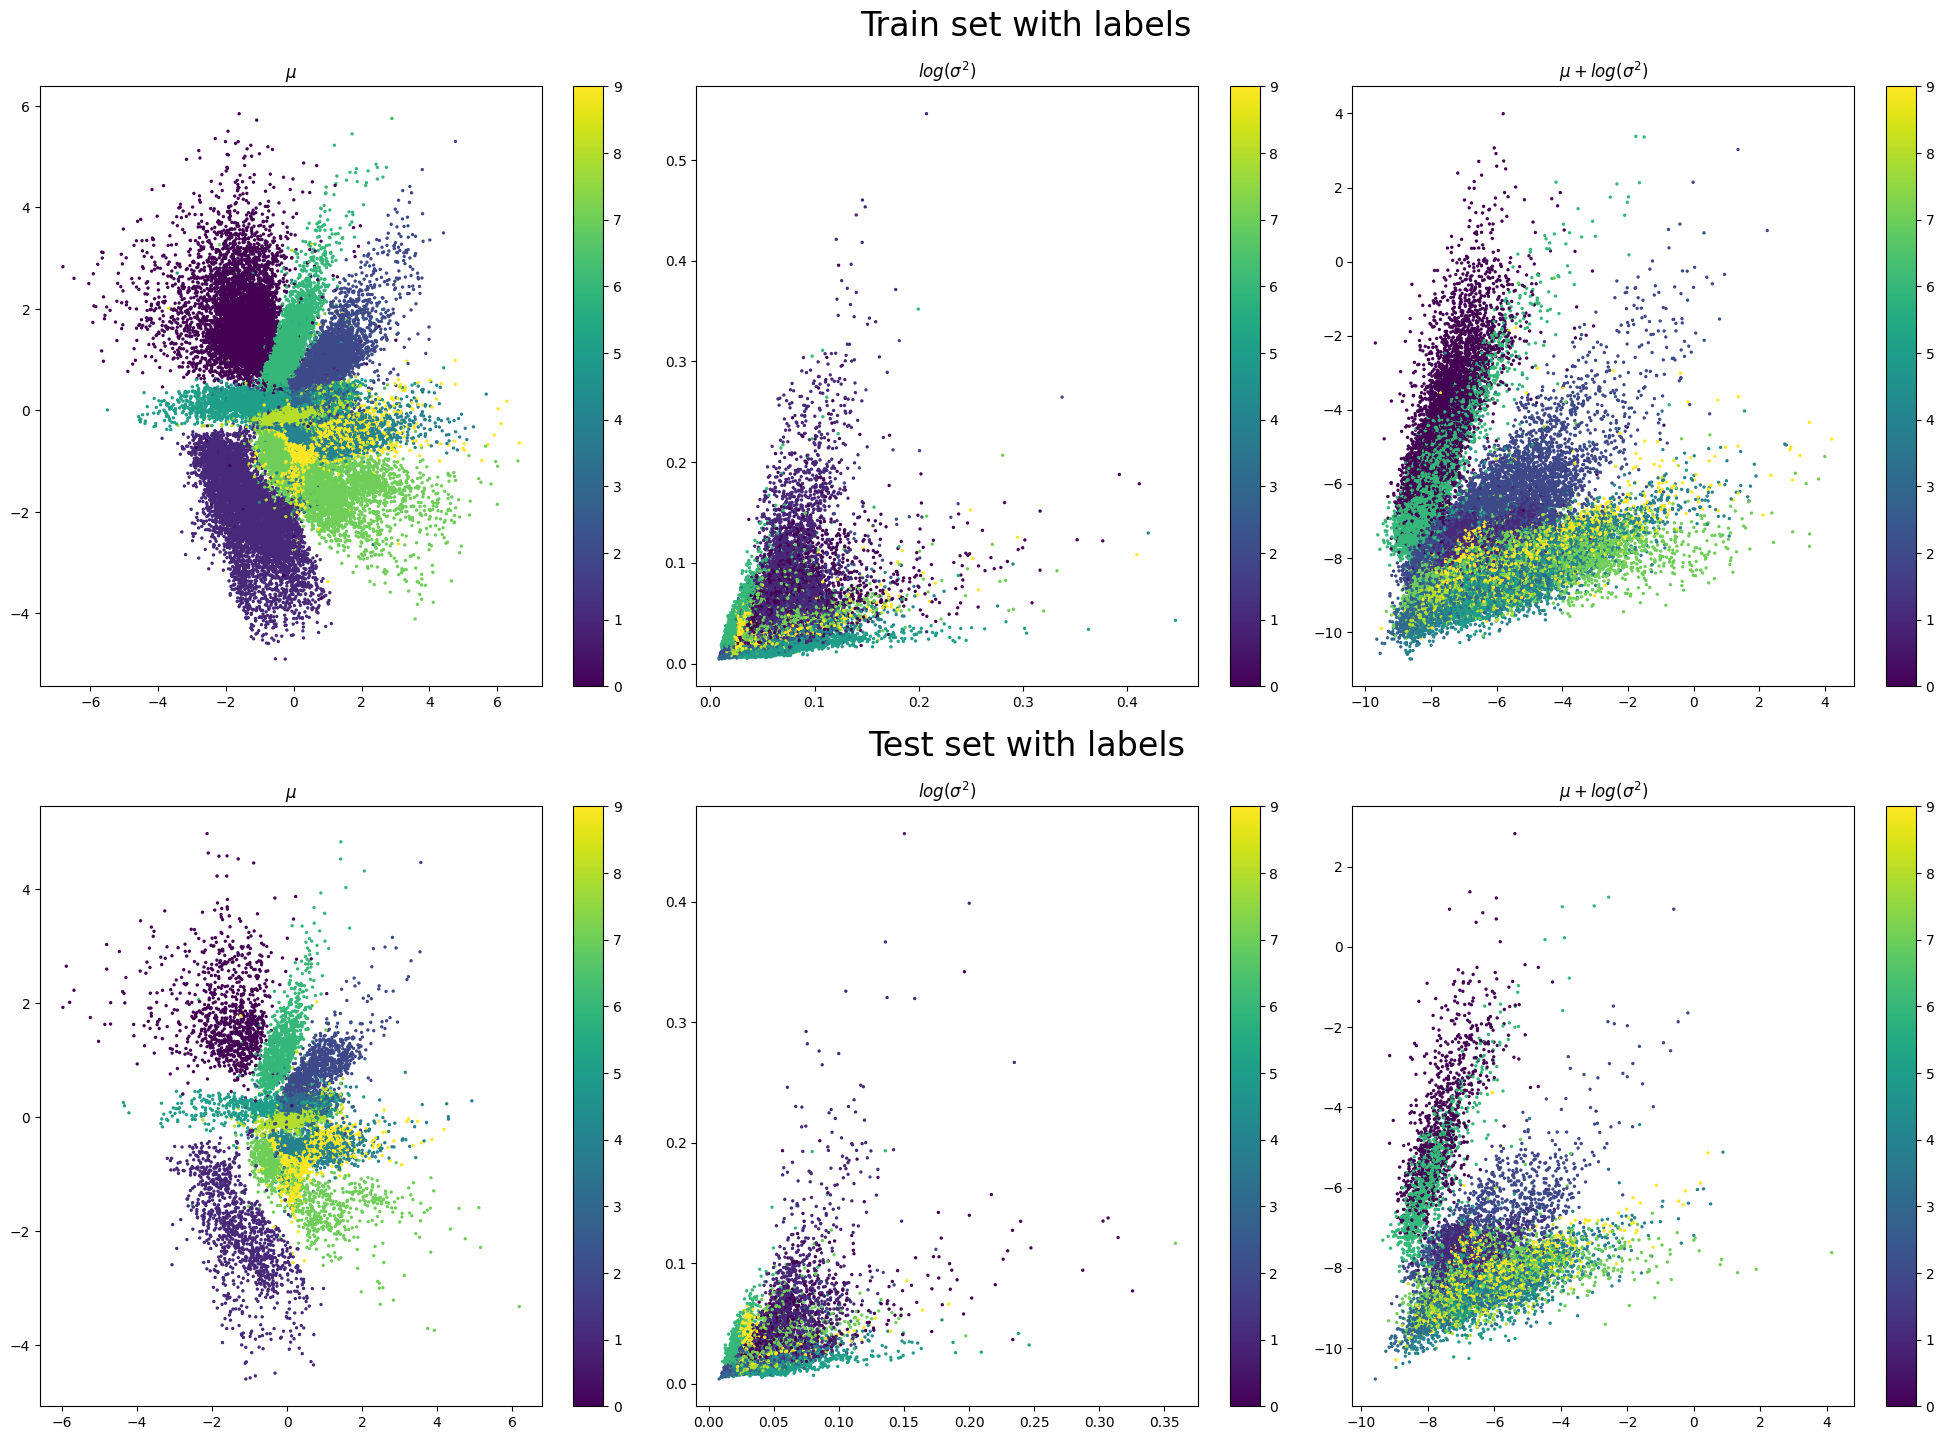

In [12]:
t_mu, t_log_var, t_mu_log_var = showLatent(model, X_train, X_test, batch_size, y_train, y_test,
                                           device if not on_device else None)

## Linear interpolation

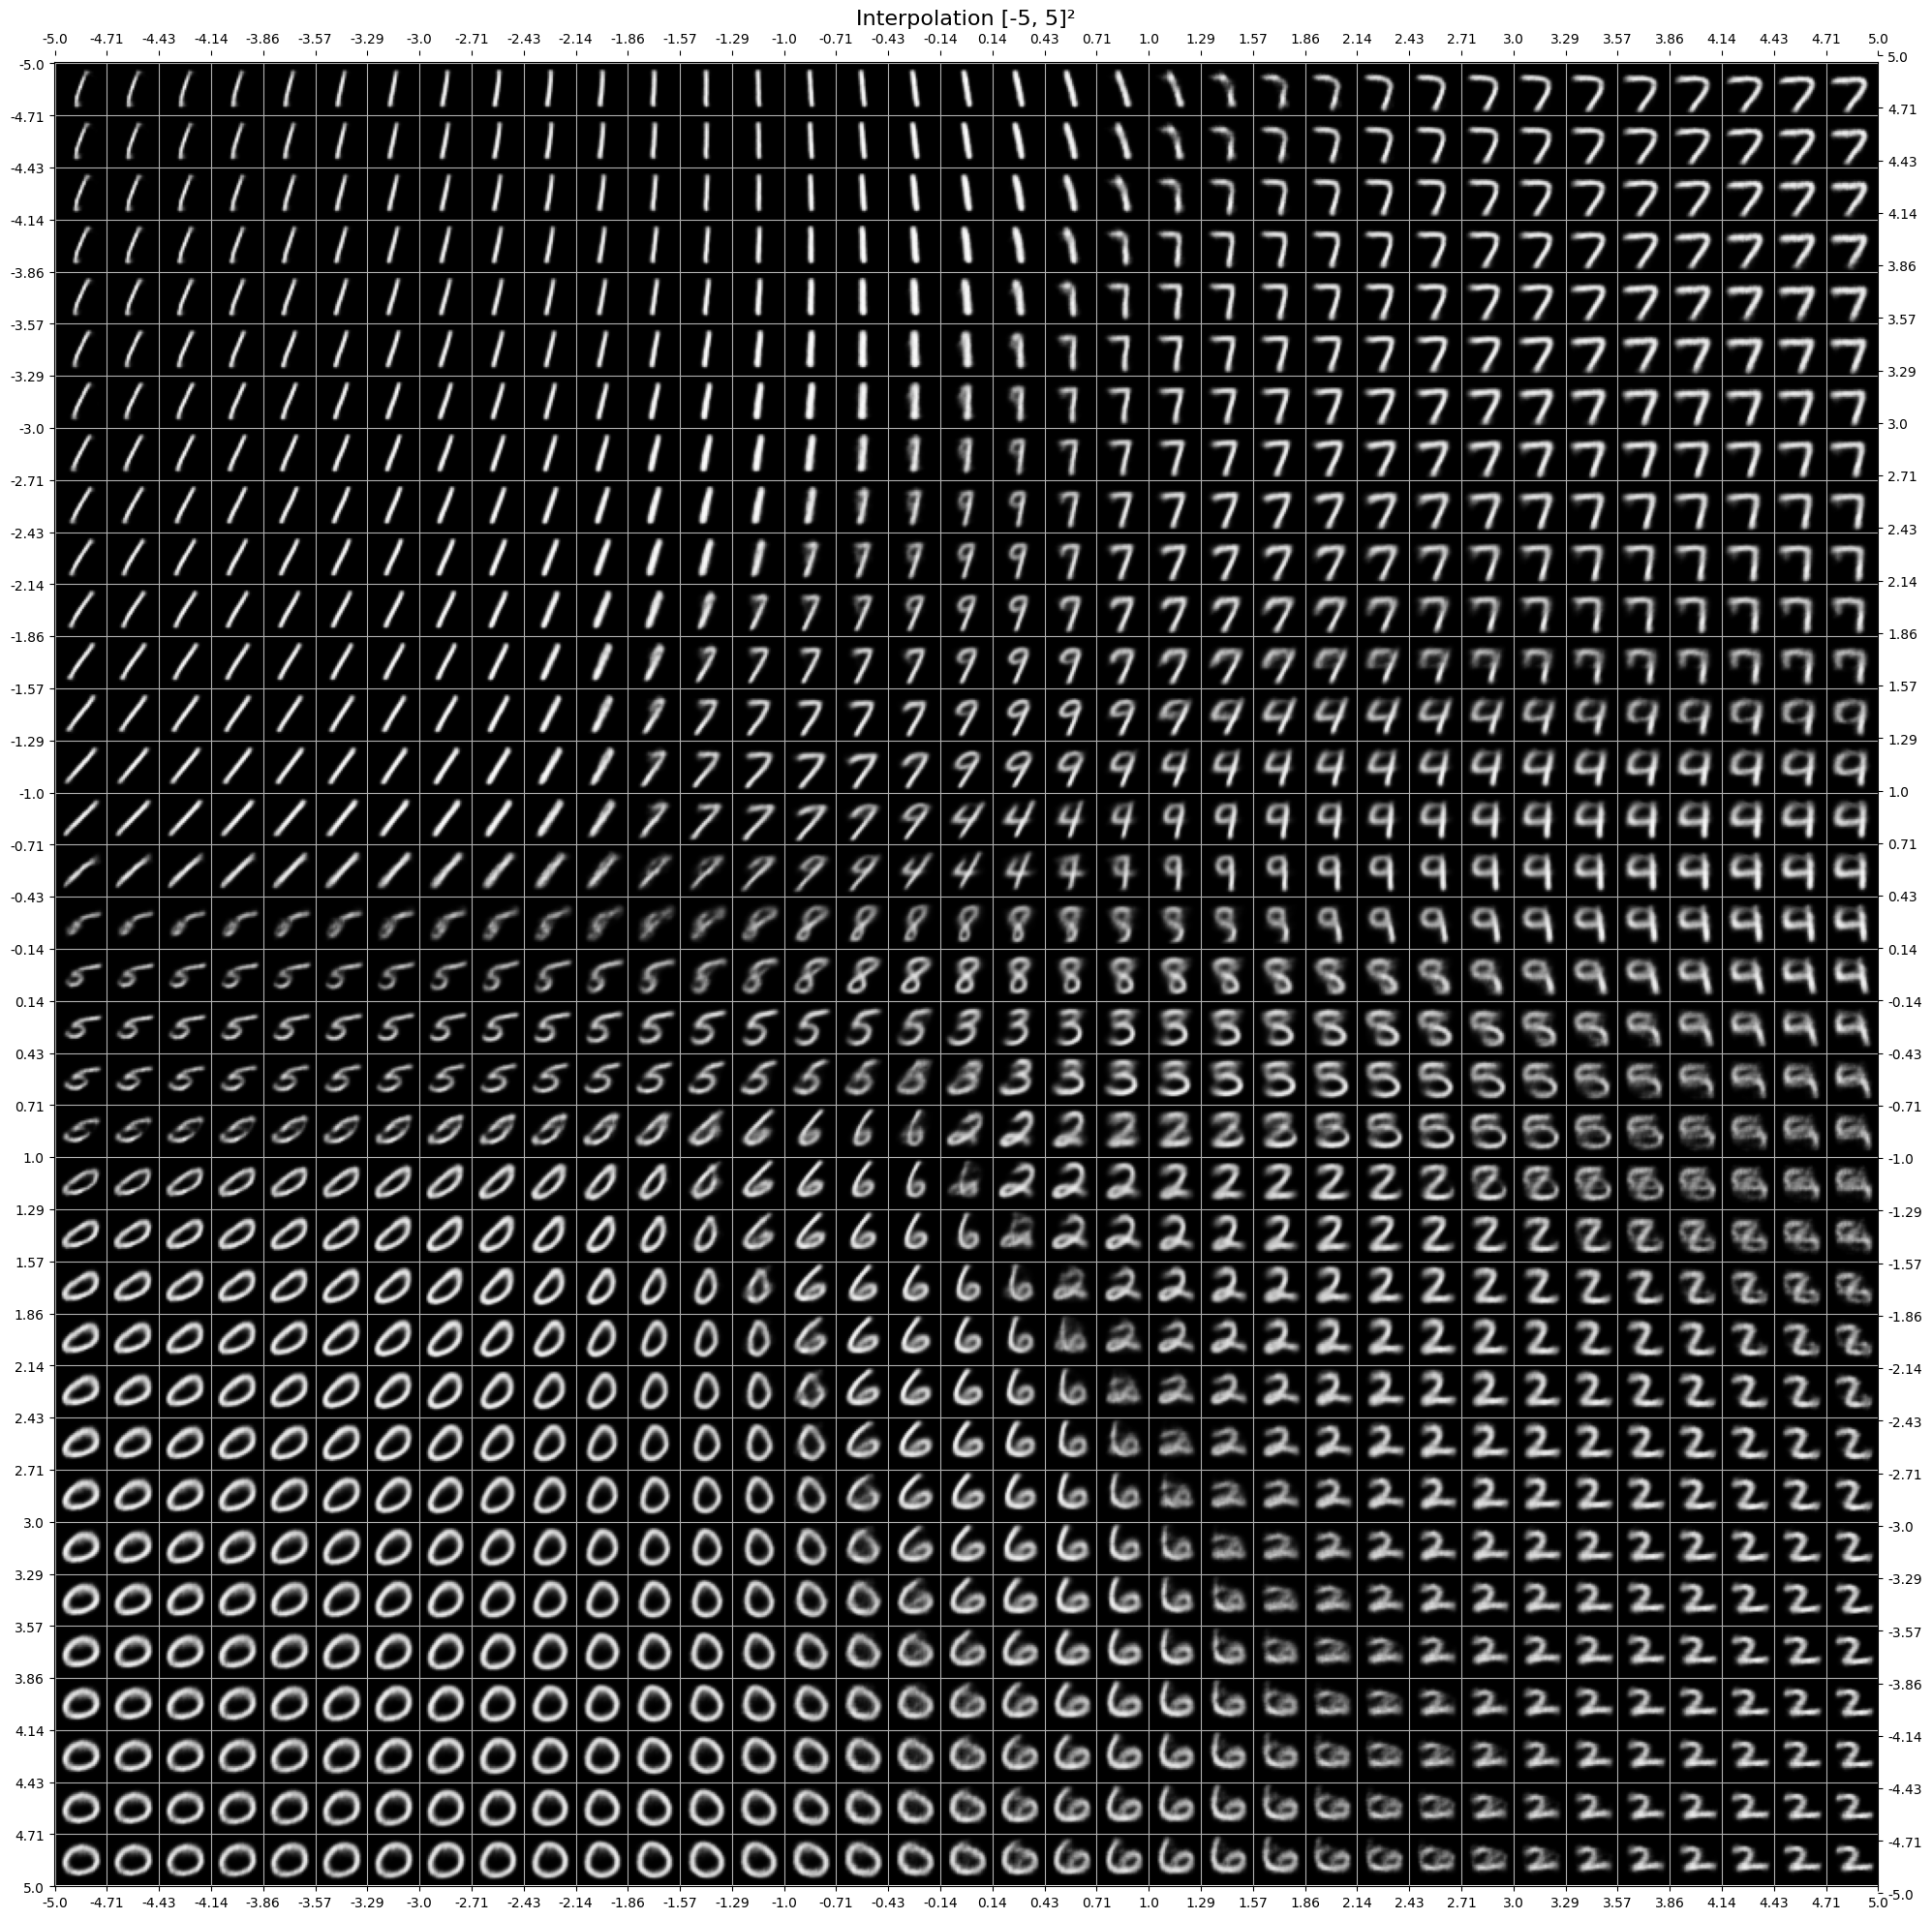

In [13]:
showInterpolation(model, output_shape, device, 35, (-5, 5))

_2021 Pierre Saunders @saundersp_